In [21]:
import pandas as pd
import argparse
import random
import time
import os
import duckdb
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.cluster import KMeans
%matplotlib inline
import sys
sys.path.append(os.path.abspath(os.getcwd()+'/..'))

from config_loc import get_data_db_folder
from featurelib.lib_v1 import *

con = duckdb.connect(os.path.join(get_data_db_folder(),"my_database.db"),read_only=True)

g_folder = 'res_exploration_v1'

In [4]:
df=con.execute('SELECT close_time,dscode,close,volume,taker_buy_volume FROM klines;').df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
# we need to convert dscode to an integer 
df['dscode_str']=df['dscode'].copy()
df['dscode']=pd.Categorical(df['dscode_str']).codes
df['dtsi'] = df['close_time'].astype('int64')

df.sort_values('close_time',ascending=True,inplace=True)

featd={col: df[col].values for col in df.columns}

In [6]:
## adding returns
featd,nfeats=perform_diff(featd=featd,feats=['close'],windows=[1],folder=g_folder,name='None')
featd['tret']=np.divide(
                featd[nfeats[0]],
                featd['close'],
                out=np.zeros_like(featd['close']),
                where=~np.isclose(featd['close'], np.zeros_like(featd['close'])))


## adding the weight ewm(volume)
featd,nfeats=perform_ewm(featd=featd,feats=['volume'],windows=[1000],folder=g_folder,name='None')
featd['wgt'] = featd[nfeats[0]]

Stepper creating instance res_exploration_v1 None_close_diff1
Stepper creating instance res_exploration_v1 None_volume_ewm1000


In [7]:
dft = pd.DataFrame(featd)
pdft=dft.pivot_table(index='close_time',columns='dscode_str',values='tret')

<Axes: xlabel='close_time'>

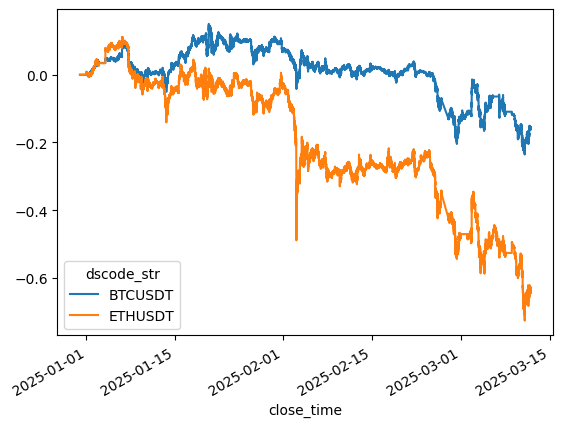

In [8]:
pdft[['BTCUSDT','ETHUSDT']].fillna(0.0).cumsum().plot()

<Axes: xlabel='close_time'>

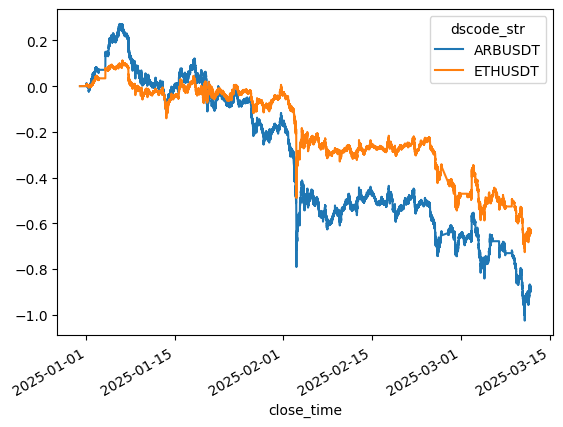

In [24]:
pdft[['ARBUSDT','ETHUSDT']].fillna(0.0).cumsum().plot()

<Axes: xlabel='close_time'>

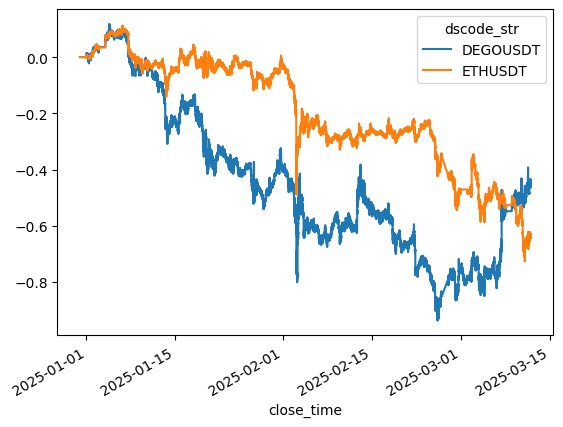

In [25]:
pdft[['DEGOUSDT','ETHUSDT']].fillna(0.0).cumsum().plot()

In [10]:
corr_matrix = pdft.corr()

In [18]:
# Compute the distance as 1 - correlation (absolute or raw value)
# (Here we use 1 - corr; if you want absolute distance, you can use 1 - np.abs(corr))
dist_matrix = 1 - corr_matrix.fillna(0.0)

# Perform hierarchical clustering using 'average' linkage
link = linkage(dist_matrix, method='average')
# Determine the order of the leaves (i.e. reordering the matrix)
order = leaves_list(link)

# Reorder the correlation matrix and labels
ordered_corr = corr_matrix.iloc[order, :].iloc[:, order]
ordered_labels = ordered_corr.columns


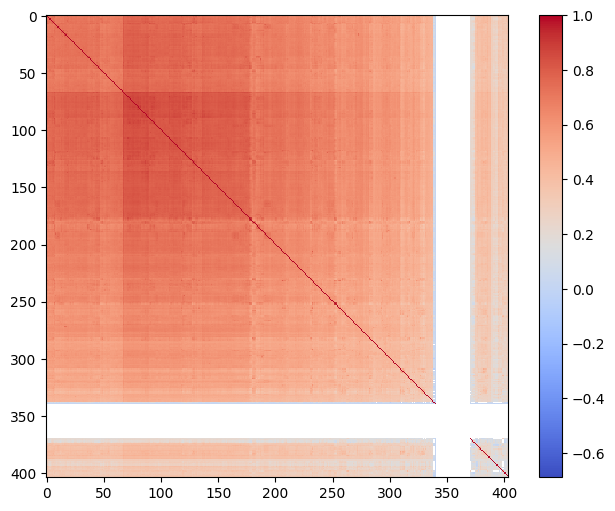

In [19]:

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(ordered_corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()


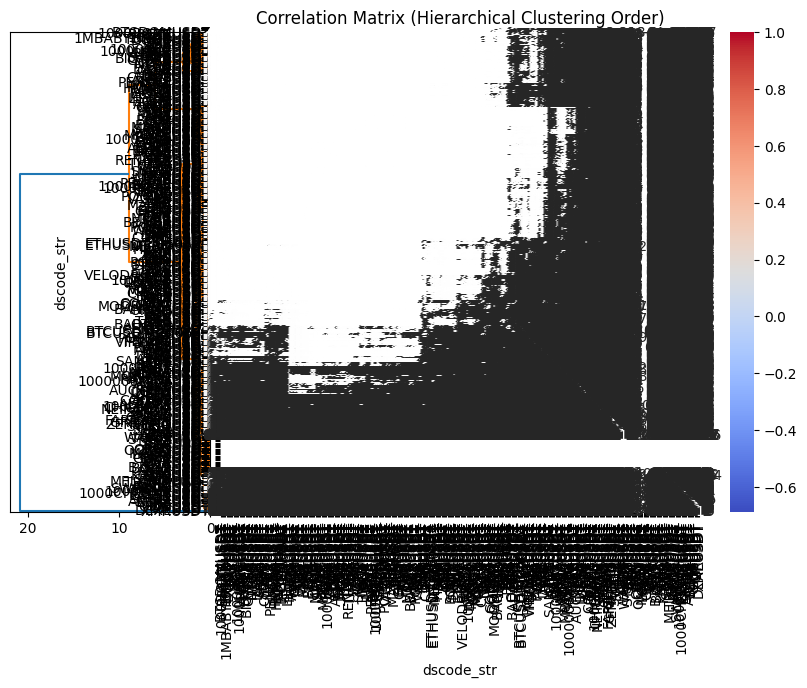

Reordered correlation matrix exported to ordered_correlation_hierarchical.xlsx


In [ ]:

# Export the reordered correlation matrix to Excel
excel_path = 'ordered_correlation_hierarchical.xlsx'
ordered_corr.to_excel(excel_path, sheet_name='Hierarchical Order')
print(f"Reordered correlation matrix exported to {excel_path}")



In [ ]:
########################
# 2. KMeans Clustering
########################
# Here we use k-means clustering on the columns of the correlation matrix.
# The idea is to cluster similar variables together and then sort by cluster labels.
# Note: You may need to adjust 'n_clusters' based on your data.
n_clusters = 3
# For clustering, we can use the correlation values or the distance
# In this example, we cluster on the correlation matrix rows.
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Fit on the correlation matrix (using the rows as features)
clusters = kmeans.fit_predict(corr)

# Create a DataFrame with cluster labels and variable names
cluster_df = pd.DataFrame({'Variable': corr.columns, 'Cluster': clusters})
# Sort by cluster (and optionally, within cluster, by the variable name or correlation profile)
cluster_df = cluster_df.sort_values(by='Cluster')